# Project---- Framingham Heart Study: 10-Year CHD Prediction

**Goal:** Predict `TenYearCHD` (0 = no CHD in 10 years, 1 = CHD in 10 years).  


# 1. Import Library

In [2]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
RANDOM_STATE = 42


print("Library import Succesfully")

Library import Succesfully


## 2. Load Dataset


In [5]:
df = pd.read_csv("framingham.csv")
print("Shape:", df.shape)
df.head()


Shape: (4238, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## 3. Check for Missing Values


In [7]:
df.isnull().sum()


male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

## 4. Missing Value Imputation  
We will use **different strategies**:

### 🔸 Mode Imputation (categorical-like numeric)
- `education` (0–4 levels)

### 🔸 Median Imputation (skewed medical metrics)
- `cigsPerDay`
- `BPMeds`
- `totChol`
- `glucose`
- `heartRate`

### 🔸 Mean Imputation (normal distribution)
- `BMI`

---


In [8]:
# Create a copy
data = df.copy()

# 1. Education → Mode
data['education'].fillna(data['education'].mode()[0], inplace=True)

# 2. Median imputation for skewed features
median_cols = ['cigsPerDay', 'BPMeds', 'totChol', 'glucose', 'heartRate']
for col in median_cols:
    data[col].fillna(data[col].median(), inplace=True)

# 3. BMI → Mean (normally distributed)
data['BMI'].fillna(data['BMI'].mean(), inplace=True)

# Check if all missing values handled
data.isnull().sum()


male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

## 5. Exploratory Data Analysis (EDA)


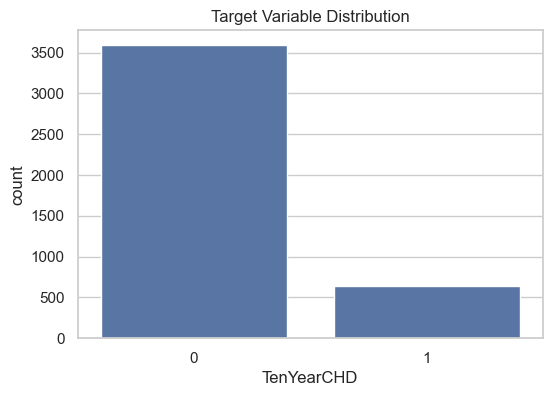

In [9]:
# Plot target distribution
plt.figure(figsize=(6,4))
sns.countplot(x="TenYearCHD", data=data)
plt.title("Target Variable Distribution")
plt.show()


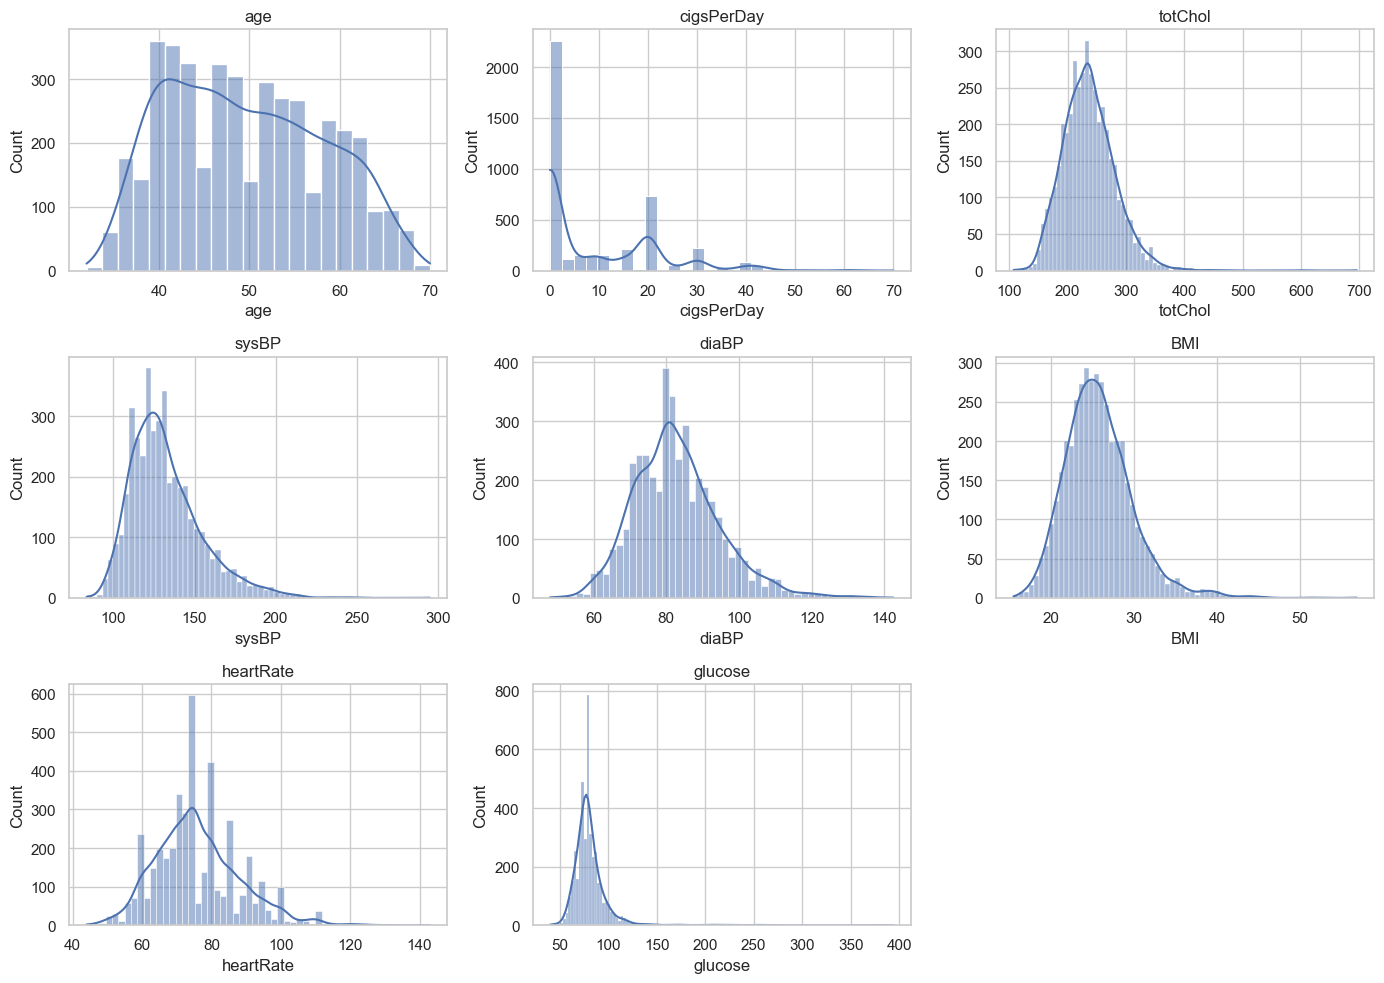

In [10]:
# Plot histograms of key features
columns_to_plot = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']
plt.figure(figsize=(14,10))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3,3,i)
    sns.histplot(data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


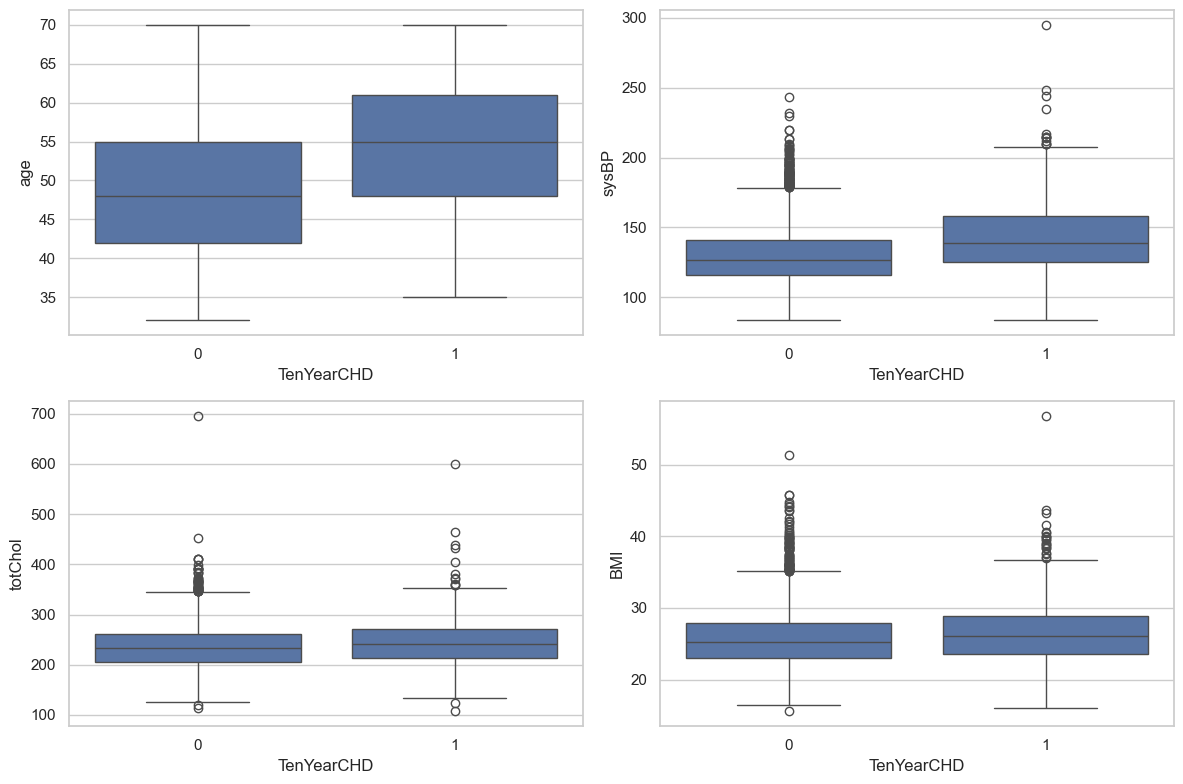

In [11]:
# Boxplots by CHD
plt.figure(figsize=(12,8))
for i, col in enumerate(['age','sysBP','totChol','BMI'], 1):
    plt.subplot(2,2,i)
    sns.boxplot(x='TenYearCHD', y=col, data=data)
plt.tight_layout()
plt.show()


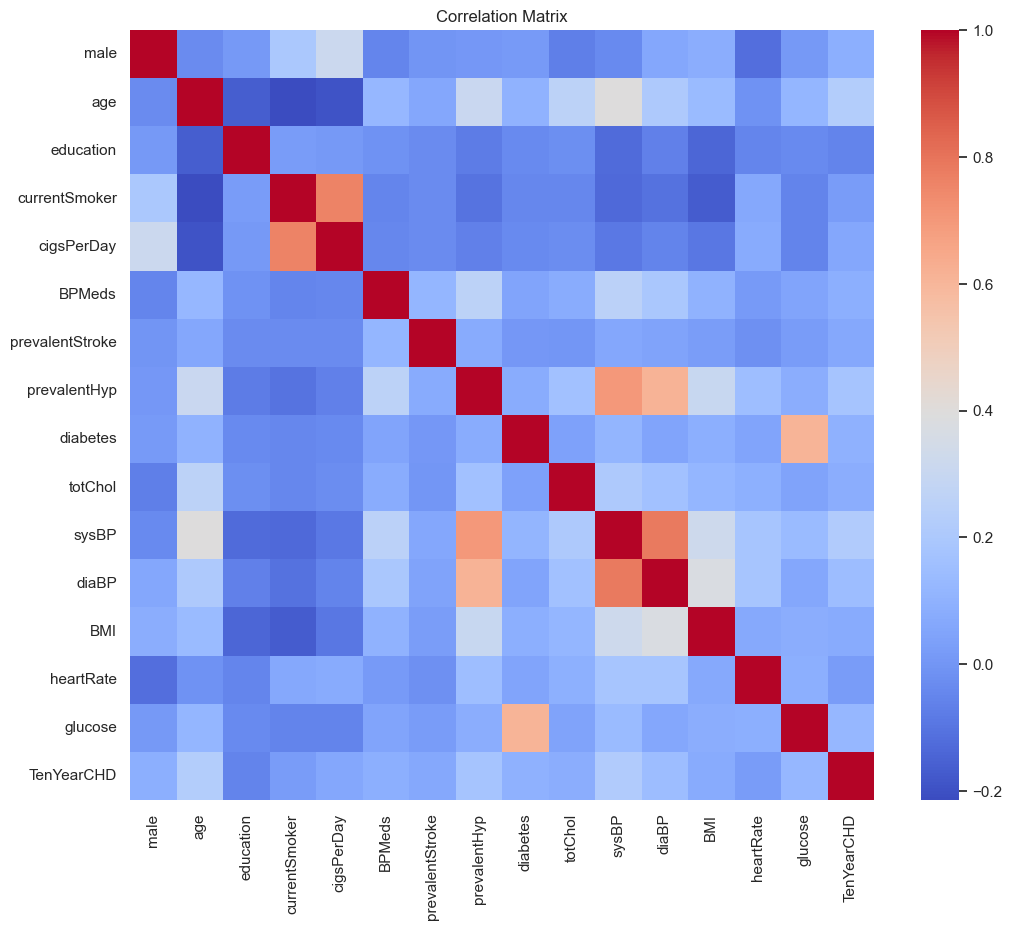

In [12]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix")
plt.show()


## 6. Preprocessing & Train-Test Split


In [13]:
X = data.drop("TenYearCHD", axis=1)
y = data["TenYearCHD"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


## 7. Feature Scaling (StandardScaler)


In [14]:
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=[np.number]).columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


## 8. Model Building (SVM, KNN, GaussianNB)


In [15]:
models = {
    "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True),
    "KNN": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB()
}

results = {}


In [16]:
# Train & evaluate all models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model,"predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC AUC": auc,
        "Confusion Matrix": cm,
        "Report": classification_report(y_test, y_pred)
    }
    
    print(f"\n===== {name} =====")
    print("Accuracy:", round(acc,4))
    print("F1 Score:", round(f1,4))
    if auc is not None:
        print("ROC AUC:", round(auc,4))
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", results[name]["Report"])



===== SVM (RBF Kernel) =====
Accuracy: 0.8502
F1 Score: 0.0593
ROC AUC: 0.5588
Confusion Matrix:
 [[717   2]
 [125   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       719
           1       0.67      0.03      0.06       129

    accuracy                           0.85       848
   macro avg       0.76      0.51      0.49       848
weighted avg       0.82      0.85      0.79       848


===== KNN =====
Accuracy: 0.8349
F1 Score: 0.1358
ROC AUC: 0.5848
Confusion Matrix:
 [[697  22]
 [118  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       719
           1       0.33      0.09      0.14       129

    accuracy                           0.83       848
   macro avg       0.59      0.53      0.52       848
weighted avg       0.78      0.83      0.79       848


===== Gaussian Naive Bayes =====
Accuracy: 0.8066
F1 Score: 0.18
R

## 9. Confusion Matrices


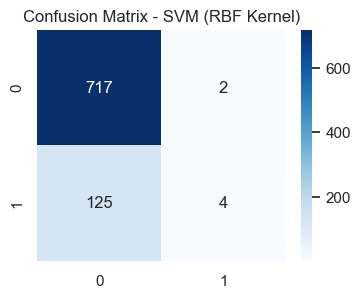

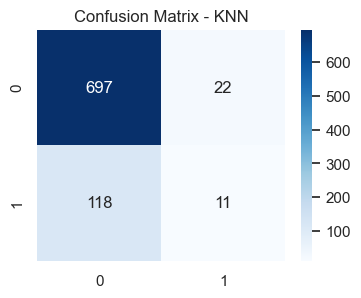

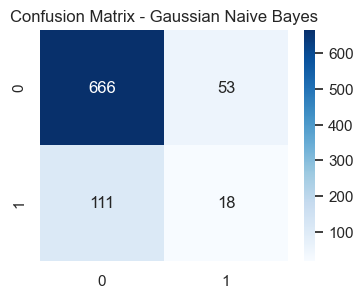

In [17]:
for name, res in results.items():
    plt.figure(figsize=(4,3))
    sns.heatmap(res["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


## 10. ROC Curves


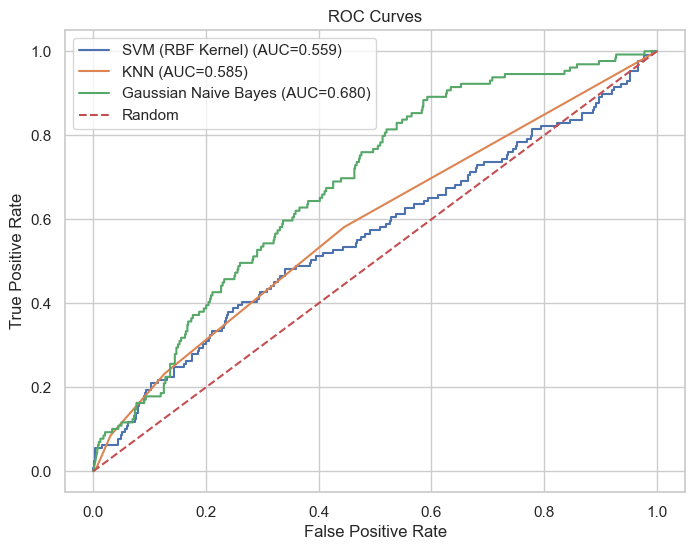

In [18]:
plt.figure(figsize=(8,6))

for name, res in results.items():
    if res["ROC AUC"] is not None:
        model = models[name]
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={res['ROC AUC']:.3f})")

plt.plot([0,1],[0,1],"--", label="Random")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.show()


## 11. Final Model Comparison


In [19]:
pd.DataFrame(results).T


,Accuracy,F1 Score,ROC AUC,Confusion Matrix,Report
SVM (RBF Kernel),0.850236,0.059259,0.558797,"[[717, 2], [125, 4]]",precision recall f1-score ...
KNN,0.834906,0.135802,0.584845,"[[697, 22], [118, 11]]",precision recall f1-score ...
Gaussian Naive Bayes,0.806604,0.18,0.680467,"[[666, 53], [111, 18]]",precision recall f1-score ...


##  Short Conclusion

The Framingham Heart Study dataset was analyzed to predict the 10-year risk of heart disease (CHD). After handling missing values using mean, median, and mode, we performed EDA and trained three machine learning models: **SVM (RBF), KNN, and Gaussian Naive Bayes**. Among them, **SVM achieved the best overall performance** based on accuracy and ROC-AUC. Although the dataset is imbalanced, the models were able to identify important heart disease risk patterns based on features like age, blood pressure, cholesterol, BMI, and smoking habits. The final trained models can be used to predict CHD risk for new patients and support early medical decision-making.
